In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../../code/')
import utils
import leakage
import reframed
# import cobra
import scipy

# Estimate release rates for S. cerevisiae in glucose from Paczia et al. 2012

In [23]:
organism = 'yeast'
data_folder = Path('../../../data')
supp_figure_folder = Path('../../../SupplementalFigures')

exometabolites_folder = data_folder / 'paczia_2012' /f"{organism}"
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [24]:
# Use mean of values in Myers et al., 2013 (https://doi.org/10.1186/2046-1682-6-4)
gDW_per_OD = np.mean([0.644, 0.848])

In [25]:
gDW_per_OD

np.float64(0.746)

In [26]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'yeast')

In [27]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())


,OD mean,OD std
Time,,
0,0.790,0.174697
1,0.807,0.174697
2,1.170,0.098995
3,1.950,0.084853
4,3.000,0.127279
5,4.675,0.077782
6,6.805,0.049497
7,7.010,0.197990
8,6.750,0.608112


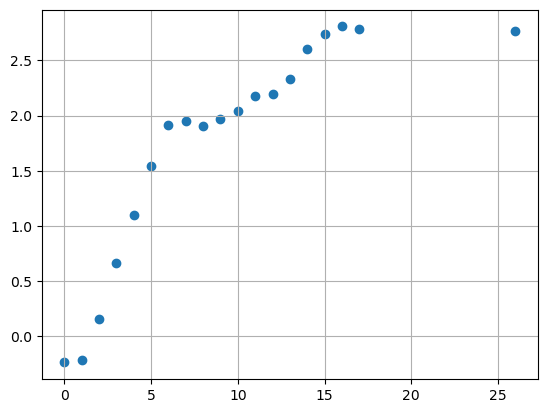

In [28]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

# Estimate max glucose uptake rate


In [29]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [30]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [31]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

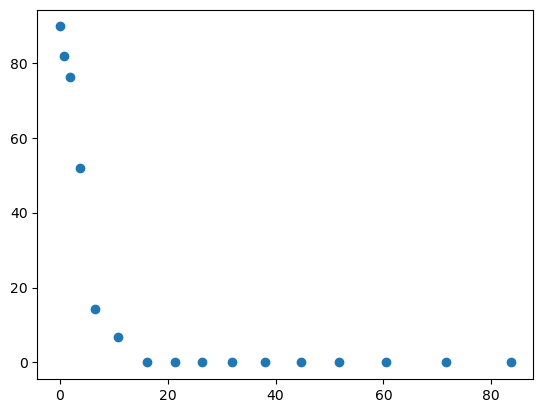

In [32]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [33]:
df_OD.loc[1:6, 'Cum OD gDW']

Time
1     0.000000
2     0.737421
3     1.849334
4     3.678899
5     6.480751
6    10.734505
Name: Cum OD gDW, dtype: float64

In [34]:
glucose_uptake = np.polyfit(df_OD.loc[1:6, 'Cum OD gDW'], df_glucose.loc[1:6, 'Glucose mM'], 1)[0]


## Mapping

In [35]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Yeast metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv = {value:key for key, value in met_abrv_to_name.items()}


# Estimate biomass area under the curve (AUC)

## Simpson integration

In [36]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.807 0.595681
2 1.17 1.2900826666666667
3 1.95 2.4279191666666664
4 3.0 4.266622666666667
5 4.675 7.0905435
6 6.805 11.354866
7 7.01 16.627531833333332
8 6.75 21.698155999999997
9 7.15 26.841826
10 7.74 32.41320266666666
11 8.86 38.572054333333334
12 9.025 45.394845999999994
13 10.265 52.52318683333333
14 13.53 61.21377599999999
15 15.47 72.11314683333332
16 16.57 84.086136
17 16.23 96.410056


In [37]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])


Text(0, 0.5, 'Cumulative gDW')

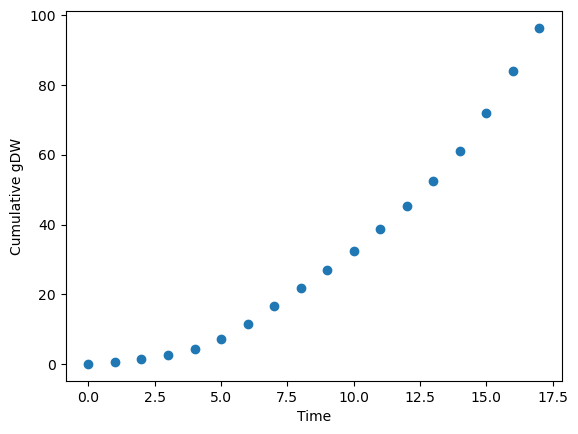

In [38]:
plt.scatter(df_OD.index[:-1], x)
plt.xlabel('Time')
plt.ylabel('Cumulative gDW')

# Fit with custom limits

In [39]:
specific_limits = {
'G6P': (4,6),
'F6P': (1,6),
'FBP': (1,6),
'DHAP': (1,6),
'23PG': (4,6),
'PEP': (1,6),
'RU5P+X5P': (1,6),
'CIT': (3,6),
'ACN': (4,6),
'ICIT': (1,6),
'SUC': (1,5),
'ASN': (1,6),
'GLU': (1,6),
'SER': (1,6),
'ASP': (1,6),
'GLN': (1,4),
'TYR': (1,6),
'PRO': (1,5),
'ALA': (1,6),
'MET': (1,6),
'VAL': (1,5),
'PHE': (1,5),
'LEU+ILEU': (1,6),
'HIS': (1,6),
'LYS': (1,4),
'ARG': (1,6),
'PYR': (1,6),
'ORO': (1,6),
'FUM': (2,6),
'URA': (1,6),
'AKG': (1,6),
'SHI': (1,6),
'ACT': (1,6),
'ETH': (1,6)}

In [40]:
auc_end_exp_phase = x[6]
auc_end_exp_phase2 = x[16]

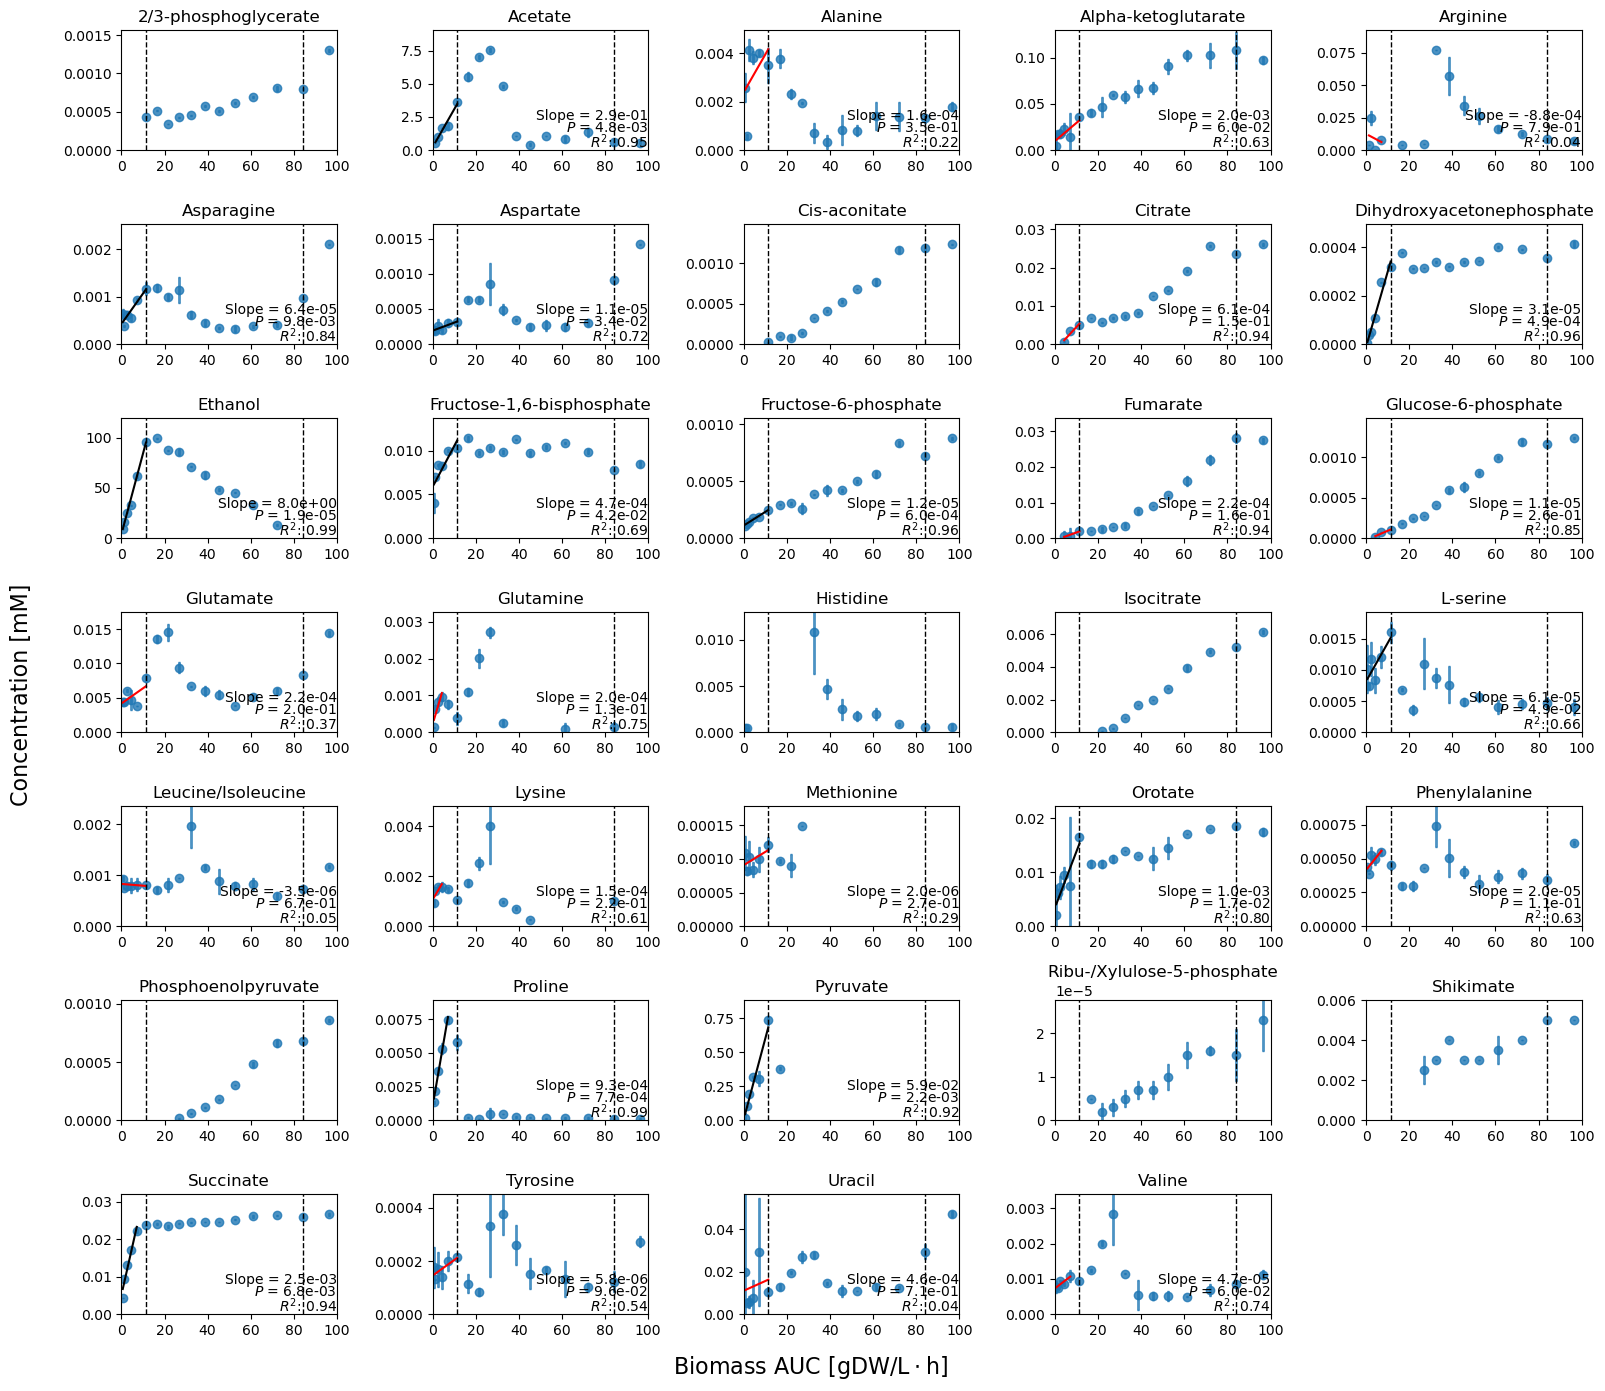

In [61]:
rate_dict_m = {}
fig, axes = plt.subplots(7,5, figsize = (16, 14), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
metabolite_names = sorted([met_abrv_to_name[c] for c in concentrations.columns])
for i,metabolite in enumerate(metabolite_names):
    c = met_name_to_abrv[metabolite]

    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    conc[conc==0] = np.nan
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1] & np.isfinite(conc)
    rate_conc = conc[idx]
    
    ax = axes[i]
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    
    if len(rate_conc) >= 3:
        # conc[conc==0] = np.nan
        res = scipy.stats.linregress(x[idx], conc[idx])
        # print(f"R-squared: {res.rvalue**2:.6f}")
        r2 = res.rvalue**2
        data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
        x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
        y_fit = fun(x_fit, res.slope, res.intercept)
    
        # if res.pvalue < 0.05:
        if (r2 >= 0.5) & (res.pvalue < 0.05):
            ax.plot(x_fit, y_fit, 'k')
        else:
            ax.plot(x_fit, y_fit, 'r')
    else:
        data = [np.nan, np.nan, np.nan, c, np.nan, np.nan]

    data_list.append(data)

    ax.axvline(auc_end_exp_phase, color='k', linestyle='--', lw = 1, label='End of exponential phase')
    ax.axvline(auc_end_exp_phase2, color='k', linestyle='--', lw = 1, label='End of exponential phase')
    ax.set_title(metabolite)
    ax.set_xlim(0, 100)
    y_max = np.max(conc)*1.2
    if np.isfinite(y_max):
        ax.set_ylim(0, y_max)
    if len(rate_conc) >= 3:
        ax.annotate(f'Slope = {res.slope:.1e}', (100, y_max*0.25), ha = 'right')
        ax.annotate(f'$P$ = {res.pvalue:.1e}', (100, y_max*0.15), ha = 'right')
        ax.annotate(f'$R^2$: {r2:.2f}', (100, y_max*0.02), ha = 'right')
    i +=1
        # print(i)

while i<(7*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel(r'Biomass AUC [$\rm{gDW/L \cdot h}$]', fontsize=16)
fig.supylabel('Concentration [mM]', x = 0, fontsize = 16)

plt.tight_layout()
plt.savefig(supp_figure_folder / 'yeast_paczia_12_fitted_rates_manual_limits.png', dpi = 400)
plt.savefig(supp_figure_folder / 'yeast_paczia_12_fitted_rates_manual_limits.pdf')

plt.show()

In [42]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

# Get model

## Functions

In [43]:


def print_summary_r(model, solution):
    # Print uptake
    for r_id in model.get_exchange_reactions():
        flux = solution.values[r_id]
        r = model.reactions[r_id]
        if  flux >1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
        elif flux < -1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution.values['R_r_2111'])
    print("Prot pool exchange: ", solution.values['R_prot_pool_exchange'])

In [44]:
model_fn = '../../../models/S_cerevisiae/ecYeastGEM_batch_8_3_4_no_rev_ex.xml'
model_ez = reframed.load_cbmodel(model_fn)
model_ez.solver = 'gurobi'
# glucose_uptake = -8.4
# model_ez = cobra.io.read_sbml_model(model_fn)

In [45]:
glucose_uptake

np.float64(-8.411115739878444)

In [46]:
# model_ez.reactions.get_by_id('r_1714').lower_bound = glucose_uptake
# solution = model_ez.optimize()
solution = reframed.FBA(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)})
print_summary_r(model_ez, solution)

Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18
R_r_1634 acetate exchange 3.076129409334051 0.0 inf
R_r_1654 ammonium exchange -2.4333341615307607 -inf inf
R_r_1672 carbon dioxide exchange 9.153597056020779 0.0 inf
R_r_1714 D-glucose exchange -8.411115739878444 -inf 0.0
R_r_1761 ethanol exchange 4.220738246536834 0.0 inf
R_r_1793 formate exchange 0.015222610164329799 0.0 inf
R_r_1832 H+ exchange -0.3571547379868423 -inf inf
R_r_1992 oxygen exchange -6.276836096433527 -inf 0.0
R_r_2005 phosphate exchange -0.09712693161002764 -inf inf
R_r_2020 potassium exchange -0.0012893081166879233 -inf inf
R_r_2033 pyruvate exchange 4.048247815594846 0.0 inf
R_r_2049 sodium exchange -0.0014100697584713648 -inf inf
R_r_2060 sulphate exchange -0.03251418409694331 -inf inf
R_r_2100 water exchange 15.385314634052152 -inf inf
R_r_2111 growth 0.35518129936306425 0.0 inf
R_prot_pool_exchange prot_pool_exchange 0.103720024310

In [47]:
# model_mets = [m.id for m in model_ez.metabolites]#[:6]
measured_metabolites = []
for value in met_abrv_to_id.values():
    if not isinstance(value, str):
        continue
    bigg_ids = value.split(', ')
    for bigg_id in bigg_ids:
        # m_id = f'{bigg_id}[c]'
        m_id = f'M_{bigg_id}__91__c__93__'
        if m_id in model_ez.metabolites:
        # if m_id in model_mets:
            measured_metabolites.append(m_id)#

# Turnover

In [48]:
solution = reframed.pFBA(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)})
turnover = solution.get_metabolites_turnover(model_ez)
# with model_ez as model:
#     model.reactions.get_by_id('r_1714').lower_bound = glucose_uptake
#     solution = cobra.flux_analysis.pfba(model)
# turnover = {}
# for m_id in measured_metabolites:
#     m = model_ez.metabolites.get_by_id(m_id)
#     turnover[m_id] = m.summary(solution).producing_flux['flux'].sum()

    

# Shadow prices

In [49]:
model_ez.get_exchange_reactions()

['R_r_1542',
 'R_r_1545',
 'R_r_1546',
 'R_r_1547',
 'R_r_1548',
 'R_r_1549',
 'R_r_1550',
 'R_r_1551',
 'R_r_1552',
 'R_r_1553',
 'R_r_1554',
 'R_r_1563',
 'R_r_1564',
 'R_r_1565',
 'R_r_1566',
 'R_r_1572',
 'R_r_1577',
 'R_r_1580',
 'R_r_1581',
 'R_r_1586',
 'R_r_1589',
 'R_r_1598',
 'R_r_1604',
 'R_r_1621',
 'R_r_1625',
 'R_r_1627',
 'R_r_1629',
 'R_r_1630',
 'R_r_1631',
 'R_r_1634',
 'R_r_1639',
 'R_r_1641',
 'R_r_1643',
 'R_r_1648',
 'R_r_1649',
 'R_r_1650',
 'R_r_1651',
 'R_r_1654',
 'R_r_1671',
 'R_r_1672',
 'R_r_1683',
 'R_r_1687',
 'R_r_1702',
 'R_r_1705',
 'R_r_1706',
 'R_r_1709',
 'R_r_1710',
 'R_r_1711',
 'R_r_1712',
 'R_r_1714',
 'R_r_1715',
 'R_r_1716',
 'R_r_1718',
 'R_r_1727',
 'R_r_1730',
 'R_r_1749',
 'R_r_1753',
 'R_r_1757',
 'R_r_1761',
 'R_r_1764',
 'R_r_1765',
 'R_r_1788',
 'R_r_1791',
 'R_r_1792',
 'R_r_1793',
 'R_r_1798',
 'R_r_1800',
 'R_r_1806',
 'R_r_1807',
 'R_r_1808',
 'R_r_1810',
 'R_r_1814',
 'R_r_1815',
 'R_r_1818',
 'R_r_1820',
 'R_r_1832',
 'R_r_1834',

In [50]:
sol = reframed.FBA(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)})
{model_ez.reactions[x].name:sol.values[x] for x in model_ez.get_exchange_reactions() if sol.values[x] > 1e-3}

{'acetate exchange': 3.076129409334051,
 'carbon dioxide exchange': 9.153597056020779,
 'ethanol exchange': 4.220738246536834,
 'formate exchange': 0.015222610164329799,
 'pyruvate exchange': 4.048247815594846,
 'water exchange': 15.385314634052152,
 'growth': 0.35518129936306425,
 'prot_pool_exchange': 0.103720024310123}

In [51]:
if len(measured_metabolites):
    shadow_prices = leakage.estimate_shadow_prices_reframed(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)},
                                                        metabolites = measured_metabolites)
# with model_ez as model:
#     model.reactions.get_by_id('r_1714').lower_bound = glucose_uptake
#     shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)

1/48: M_s_0568__91__c__93__, predicted flux: -8.411115739878444, secretion reaction: R_r_1714
37/48: M_s_1399__91__c__93__, predicted flux: 4.048247815594846, secretion reaction: R_r_2033
42/48: M_s_0362__91__c__93__, predicted flux: 3.076129409334051, secretion reaction: R_r_1634
45/48: M_s_0680__91__c__93__, predicted flux: 4.220738246536834, secretion reaction: R_r_1761


In [52]:
glc_uptake_range = np.linspace(glucose_uptake*1.2, glucose_uptake*0.8, 5, endpoint=True)
shadow_price_list = []
for g in glc_uptake_range:
    shadow_prices_i = leakage.estimate_shadow_prices_reframed(model_ez, constraints={'R_r_1714': (g,0)}, metabolites = measured_metabolites)
    shadow_price_list.append(shadow_prices_i)
shadow_price_list.append(shadow_prices)
glc_uptake_range = np.linspace(glucose_uptake*1.2, glucose_uptake*0.8, 5, endpoint=True)

# shadow_price_list = []
# with model_ez as model:
#     for g in glc_uptake_range:   
#        model.reactions.get_by_id('r_1714').lower_bound = g
#     shadow_prices_i = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)
#     shadow_price_list.append(shadow_prices_i)
# shadow_price_list.append(shadow_prices)

1/48: M_s_0568__91__c__93__, predicted flux: -10.093338887854133, secretion reaction: R_r_1714
37/48: M_s_1399__91__c__93__, predicted flux: 1.6903625604776646, secretion reaction: R_r_2033
42/48: M_s_0362__91__c__93__, predicted flux: 3.131052655446218, secretion reaction: R_r_1634
45/48: M_s_0680__91__c__93__, predicted flux: 9.790354504905258, secretion reaction: R_r_1761
1/48: M_s_0568__91__c__93__, predicted flux: -9.252227313866289, secretion reaction: R_r_1714
37/48: M_s_1399__91__c__93__, predicted flux: 2.86930518803622, secretion reaction: R_r_2033
42/48: M_s_0362__91__c__93__, predicted flux: 3.1035910323901224, secretion reaction: R_r_1634
45/48: M_s_0680__91__c__93__, predicted flux: 7.0055463757211, secretion reaction: R_r_1761
1/48: M_s_0568__91__c__93__, predicted flux: -8.411115739878444, secretion reaction: R_r_1714
37/48: M_s_1399__91__c__93__, predicted flux: 4.048247815594846, secretion reaction: R_r_2033
42/48: M_s_0362__91__c__93__, predicted flux: 3.076129409334

In [53]:
df_sp_var = pd.DataFrame(shadow_price_list)

# Make spreadsheet

In [54]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms are used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std. Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if np.isnan(row['Rate [mmol/gDW/h]']):
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std. Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}__91__c__93__'
        # m_id = f'{bigg_id}[c]'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        # m = model_ez.metabolites.get_by_id(m_id)
        element_dict = utils.get_element_dict(m)
        Nc = element_dict['C']
        if len(bigg_ids)>1:
            print(m.name, bigg_id)
        # Nc = m.elements['C']
        # mass = m.formula_weight
        mass = utils.get_mol_weight(m)
        mv_min = -df_sp_var.max()[m_id]
        mv_max = -df_sp_var.min()[m_id]
        
        data.append([abbr, bigg_id, name, mv, mv_min, mv_max, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2'], row['p-val']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'Model ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]','MV min', 'MV max', 
                                        'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'R2', 'p-value'])

L-leucine [cytoplasm] s_1021
L-isoleucine [cytoplasm] s_1016


In [55]:
df_rate.loc[df_rate['Model ID'] == 's_1021', 'Metabolite'] = 'Leucine'
df_rate.loc[df_rate['Model ID'] == 's_1016', 'Metabolite'] = 'Isoleucine'

In [56]:
df_rate['Species'] = 'S. cerevisiae'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-12'

In [57]:
df_rate.to_csv(data_folder / 'paczia_2012' / 'paczia_12_rates_yeast.csv')